# Cohort 60x60 AUCs analysis

### Imports and environment setup

- Date of run: 2024-12-28
- Environment: python 3.12
- Packages required: pandas, numpy, sklearn, statsmodels, seaborn, matplotlib

In [1]:
# Include in the environment the code directory with the utils function
import sys
sys.path.append('../code/')

In [2]:
# Library imports
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Utils imports
import cohort_analysis_utils as utils

In [3]:
# Remove warnings for readability
import warnings
warnings.filterwarnings('ignore')

# Remove cell printing limits
pd.set_option('display.max_rows', None)


# Data loading and preprosessing

The original excel file was saved into a CSV file in the data folder of this repository, separating fields by TABs.

In [4]:
df_120 = pd.read_csv('../data/60x60_dr_mmk_20241209.csv' , sep='\t', index_col=0, header=0)


In [5]:
# Harmonization of column names
df_120 = utils.normalize_column_names(df_120)

In [6]:
# Ensure numeric columns are treated as such
cols_120_to_num = ['Collected_volume_mL', 'pH',
                    'MMP9', 'HSPB1', 'PERM', 'ADIPOQ', 'TIMP-2', 'AGRIN', 'KPYM', 'Total_protein_BCA']
df_120 = utils.cols_as_numbers(df_120, cols_120_to_num)

In [7]:
# Columns to be considered as biomarkers
BIOMARKERS_120 = ['MMP9', 'HSPB1', 'PERM', 'ADIPOQ', 'TIMP-2', 'AGRIN', 'KPYM']


### Create new columns for biomarker ratios

In [8]:
# Create new columns with the ratios between the biomarkers
for biomarker1 in BIOMARKERS_120:
    for biomarker2 in BIOMARKERS_120:
        if biomarker1 != biomarker2:
            df_120[f'{biomarker1}_{biomarker2}'] = df_120[biomarker1].div(df_120[biomarker2], axis=0)
            # Make infinite values NaN
            df_120[f'{biomarker1}_{biomarker2}'] = df_120[f'{biomarker1}_{biomarker2}'].replace([np.inf, -np.inf], np.nan)
    

In [9]:
# Ensure categorical columns are treated as such
df_120 = utils.cols_as_category(df_120, {'Pathology':{'Benign': 0, 'Endometrial cancer': 1}})

## Load pipelle results

In [124]:
df_pipelle = pd.read_csv('../data/pipelle_results_20250121.csv' , sep='\t', index_col=0, header=0)

In [11]:
# in df_120, merge the columns from df_pipelle named 'Result', using the index to match the rows, 
# make the "Material Insuficiente o ausencia de diagnóstico" to have a value of 2
# make the NaN values to have a value of 1
# make the "Cáncer" to have a value of 8
# and all the rest to have a value of 4
#remove duplicate indexes in df_pipelle
df_pipelle = df_pipelle[~df_pipelle.index.duplicated(keep='first')]
df_120['Result'] = df_120.index.map(df_pipelle['Result'])
df_120['Result'] = df_120['Result'].replace({"Material Insuficiente o ausencia de diagnóstico": 1, "Cáncer": 2})
df_120['Result'] = df_120['Result'].fillna(1)
# Now all the remaining string values are replaced by 4
df_120['Result'] = df_120['Result'].replace({value: 0 for value in df_120['Result'].unique() if type(value) == str})



In [12]:
df_120.shape

(120, 65)

In [13]:
BIOMARKERS_120 = ["MMP9_AGRIN", "AGRIN_TIMP-2", "TIMP-2_MMP9", "Result"]



# Execution parameters

In [14]:
PLOT_ROCS = False
MAX_BIOMARKER_COUNT = 2
RESULTS_PATH = '../data/results/60x60_dr_ratios_mmk_misclassifications'


NORMALIZING_COL_120 = 'Total_protein_BCA' # Column to be used for normalizing the biomarkers
VOLUME_COL = 'Collected_volume_mL' # Column to be used as volume for scatters and undoing the dilution

Since we are using ratios, we are interested only in the $direct$ method.

In [15]:
METHODS = ['direct']

# Computing the models

All the functions to generate the models are included in the [cohort_analysis_utils.py](../code/cohort_analysis_utils.py) file.

In [16]:
models_120 = utils.compute_all_models_and_save(
                            df=df_120,
                            biomarkers=BIOMARKERS_120,
                            normalizing_col=NORMALIZING_COL_120, 
                            volume_col= VOLUME_COL,
                            volume_added=0.5,
                            apply_log=True,
                            avoid_same_biomarker=True,
                            methods=METHODS,
                            max_biomarker_count=4,
                            folder_name=RESULTS_PATH,
                            plot_rocs=True,
                            auc_threshold=0.01,
                            )

## The AUC for all the computed models

In [17]:
for m in models_120['direct'][list(models_120['direct'].keys())[0]].keys():
    print(m, models_120['direct'][list(models_120['direct'].keys())[0]][m]['auc'])

('MMP9_AGRIN',) 0.47139
('AGRIN_TIMP-2',) 0.83865
('TIMP-2_MMP9',) 0.77216
('Result',) 0.94208
('MMP9_AGRIN', 'AGRIN_TIMP-2') 0.70918
('MMP9_AGRIN', 'TIMP-2_MMP9') 0.73049
('MMP9_AGRIN', 'Result') 0.91722
('AGRIN_TIMP-2', 'TIMP-2_MMP9') 0.86508
('AGRIN_TIMP-2', 'Result') 0.87915
('TIMP-2_MMP9', 'Result') 0.94511
('MMP9_AGRIN', 'AGRIN_TIMP-2', 'TIMP-2_MMP9') 0.86442
('MMP9_AGRIN', 'AGRIN_TIMP-2', 'Result') 0.9088
('MMP9_AGRIN', 'TIMP-2_MMP9', 'Result') 0.96263
('AGRIN_TIMP-2', 'TIMP-2_MMP9', 'Result') 0.93386
('MMP9_AGRIN', 'AGRIN_TIMP-2', 'TIMP-2_MMP9', 'Result') 0.96263


In [18]:
tm = ('MMP9_AGRIN', 'TIMP-2_MMP9', 'Result')

In [19]:
models_120['direct'][list(models_120['direct'].keys())[0]][tm]['auc']

0.96263

In [20]:
model = models_120['direct'][list(models_120['direct'].keys())[0]][tm]['model']

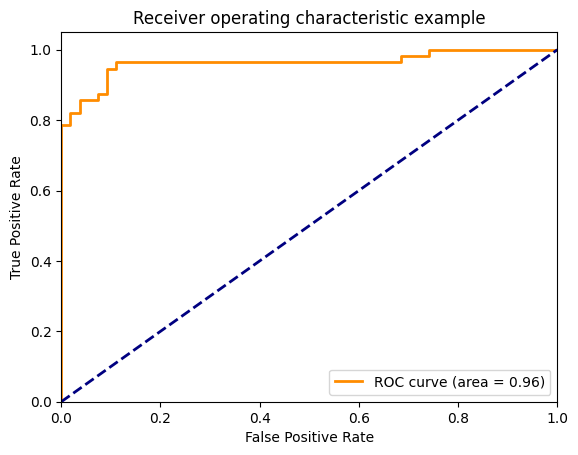

In [21]:
y = models_120['direct'][list(models_120['direct'].keys())[0]][tm]['y_true']
y_pred = models_120['direct'][list(models_120['direct'].keys())[0]][tm]['y_pred']

# plot the roc curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


## Clinical parameters in balanced cohort

In [22]:
thresholds = np.linspace(0, 1, 100)
sensitivities = []
specificities = []
npvs = []
ppvs = []
tps = []
fps = []
tns = []
fns = []
for threshold in thresholds:
    y_pred_thresholded = y_pred > threshold
    tn, fp, fn, tp = confusion_matrix(y, y_pred_thresholded).ravel()
    tps.append(tp)
    fps.append(fp)
    tns.append(tn)
    fns.append(fn)
    sensitivities.append(tp / (tp + fn))
    specificities.append(tn / (tn + fp))
    npvs.append(tn / (tn + fn))
    ppvs.append(tp / (tp + fp))


# make a dataframe with the results
df_results = pd.DataFrame({'threshold': thresholds, 'sensitivity': sensitivities, 'specificity': specificities, 'npv': npvs, 'ppv': ppvs, 'tp': tps, 'fp': fps, 'tn': tns, 'fn': fns})
# remove repeated values
df_results = df_results.drop_duplicates(subset=['sensitivity'], keep='last')

df_results['fpr'] = df_results['fp'] / (df_results['fp'] + df_results['tn'])
df_results['tpr'] = df_results['tp'] / (df_results['tp'] + df_results['fn'])
df_results['fnr'] = df_results['fn'] / (df_results['fn'] + df_results['tp'])
df_results['tnr'] = df_results['tn'] / (df_results['tn'] + df_results['fp'])

# Round the values to 3 decimal places
df_results = df_results.round(3)

df_results


,threshold,sensitivity,specificity,npv,ppv,tp,fp,tn,fn,fpr,tpr,fnr,tnr
1,0.010,1.000,0.222,1.000,0.571,56,42,12,0,0.778,1.000,0.000,0.222
2,0.020,0.982,0.278,0.938,0.585,55,39,15,1,0.722,0.982,0.018,0.278
44,0.444,0.964,0.889,0.960,0.900,54,6,48,2,0.111,0.964,0.036,0.889
58,0.586,0.946,0.907,0.942,0.914,53,5,49,3,0.093,0.946,0.054,0.907
61,0.616,0.929,0.907,0.925,0.912,52,5,49,4,0.093,0.929,0.071,0.907
62,0.626,0.911,0.907,0.907,0.911,51,5,49,5,0.093,0.911,0.089,0.907
65,0.657,0.893,0.907,0.891,0.909,50,5,49,6,0.093,0.893,0.107,0.907
73,0.737,0.875,0.926,0.877,0.925,49,4,50,7,0.074,0.875,0.125,0.926
80,0.808,0.857,0.963,0.867,0.960,48,2,52,8,0.037,0.857,0.143,0.963
81,0.818,0.839,0.963,0.852,0.959,47,2,52,9,0.037,0.839,0.161,0.963


## Clinical parameter in real prevalence cohort

In [23]:
thresholds = np.linspace(0, 1, 100)
sensitivities = []
specificities = []
npvs = []
ppvs = []
tps = []
fps = []
tns = []
fns = []
for threshold in thresholds:
    y_pred_thresholded = y_pred > threshold
    tn, fp, fn, tp = confusion_matrix(y, y_pred_thresholded).ravel()
    tps.append(tp)
    fps.append(fp * 9)
    tns.append(tn * 9)
    fns.append(fn)
    sensitivities.append(tp / (tp + fn))
    specificities.append(tn / (tn + fp))
    npvs.append(tn / (tn + fn))
    ppvs.append(tp / (tp + fp))

# make a dataframe with the results
df_results = pd.DataFrame({'threshold': thresholds, 'sensitivity': sensitivities, 'specificity': specificities, 'npv': npvs, 'ppv': ppvs, 'tp': tps, 'fp': fps, 'tn': tns, 'fn': fns})


# calculate the other metrics
df_results['sensitivity'] = df_results['tp'] / (df_results['tp'] + df_results['fn'])
df_results['specificity'] = df_results['tn'] / (df_results['tn'] + df_results['fp'])
df_results['npv'] = df_results['tn'] / (df_results['tn'] + df_results['fn'])
df_results['ppv'] = df_results['tp'] / (df_results['tp'] + df_results['fp'])
df_results['fpr'] = df_results['fp'] / (df_results['fp'] + df_results['tn'])
df_results['tpr'] = df_results['tp'] / (df_results['tp'] + df_results['fn'])
df_results['fnr'] = df_results['fn'] / (df_results['fn'] + df_results['tp'])
df_results['tnr'] = df_results['tn'] / (df_results['tn'] + df_results['fp'])

# Round to three decimal places
df_results = df_results.round(3)

# remove repeated values
df_results = df_results.drop_duplicates(subset=['sensitivity'], keep='last')

df_results


,threshold,sensitivity,specificity,npv,ppv,tp,fp,tn,fn,fpr,tpr,fnr,tnr
1,0.010,1.000,0.222,1.000,0.129,56,378,108,0,0.778,1.000,0.000,0.222
2,0.020,0.982,0.278,0.993,0.135,55,351,135,1,0.722,0.982,0.018,0.278
44,0.444,0.964,0.889,0.995,0.500,54,54,432,2,0.111,0.964,0.036,0.889
58,0.586,0.946,0.907,0.993,0.541,53,45,441,3,0.093,0.946,0.054,0.907
61,0.616,0.929,0.907,0.991,0.536,52,45,441,4,0.093,0.929,0.071,0.907
62,0.626,0.911,0.907,0.989,0.531,51,45,441,5,0.093,0.911,0.089,0.907
65,0.657,0.893,0.907,0.987,0.526,50,45,441,6,0.093,0.893,0.107,0.907
73,0.737,0.875,0.926,0.985,0.576,49,36,450,7,0.074,0.875,0.125,0.926
80,0.808,0.857,0.963,0.983,0.727,48,18,468,8,0.037,0.857,0.143,0.963
81,0.818,0.839,0.963,0.981,0.723,47,18,468,9,0.037,0.839,0.161,0.963


## Making a combined diagnostic

In [24]:
BIOMARKERS_120 = ["MMP9_AGRIN", "AGRIN_TIMP-2", "TIMP-2_MMP9"]

In [49]:
models_120_forced = utils.compute_all_models_and_save(
                            df=df_120,
                            biomarkers=BIOMARKERS_120,
                            normalizing_col=None, 
                            volume_col= None,
                            force_dx_positive_col='Result',
                            volume_added=0.5,
                            apply_log=True,
                            avoid_same_biomarker=True,
                            methods=METHODS,
                            max_biomarker_count=3,
                            folder_name=RESULTS_PATH,
                            plot_rocs=True,
                            auc_threshold=0.01,
                            )

In [50]:
for m in models_120_forced['direct'][list(models_120_forced['direct'].keys())[0]].keys():
    print(m, models_120_forced['direct'][list(models_120_forced['direct'].keys())[0]][m]['auc'])

('MMP9_AGRIN',) 0.8275
('AGRIN_TIMP-2',) 0.97034
('TIMP-2_MMP9',) 0.92063
('MMP9_AGRIN', 'AGRIN_TIMP-2') 0.92347
('MMP9_AGRIN', 'TIMP-2_MMP9') 0.9041
('AGRIN_TIMP-2', 'TIMP-2_MMP9') 0.95899
('MMP9_AGRIN', 'AGRIN_TIMP-2', 'TIMP-2_MMP9') 0.95933


In [142]:
tm = ('AGRIN_TIMP-2',)
model = models_120_forced['direct'][list(models_120_forced['direct'].keys())[0]][tm]['model']

In [143]:
y = models_120_forced['direct'][list(models_120_forced['direct'].keys())[0]][tm]['y_true']
y_pred = models_120_forced['direct'][list(models_120_forced['direct'].keys())[0]][tm]['y_pred']


In [53]:
thresholds = np.linspace(0, 1, 100)
sensitivities = []
specificities = []
npvs = []
ppvs = []
tps = []
fps = []
tns = []
fns = []
for threshold in thresholds:
    y_pred_thresholded = y_pred > threshold
    tn, fp, fn, tp = confusion_matrix(y, y_pred_thresholded).ravel()
    tps.append(tp)
    fps.append(fp * 9)
    tns.append(tn * 9)
    fns.append(fn)
    sensitivities.append(tp / (tp + fn))
    specificities.append(tn / (tn + fp))
    npvs.append(tn / (tn + fn))
    ppvs.append(tp / (tp + fp))

# make a dataframe with the results
df_results = pd.DataFrame({'threshold': thresholds, 'sensitivity': sensitivities, 'specificity': specificities, 'npv': npvs, 'ppv': ppvs, 'tp': tps, 'fp': fps, 'tn': tns, 'fn': fns})


# calculate the other metrics
df_results['sensitivity'] = df_results['tp'] / (df_results['tp'] + df_results['fn'])
df_results['specificity'] = df_results['tn'] / (df_results['tn'] + df_results['fp'])
df_results['npv'] = df_results['tn'] / (df_results['tn'] + df_results['fn'])
df_results['ppv'] = df_results['tp'] / (df_results['tp'] + df_results['fp'])
df_results['fpr'] = df_results['fp'] / (df_results['fp'] + df_results['tn'])
df_results['tpr'] = df_results['tp'] / (df_results['tp'] + df_results['fn'])
df_results['fnr'] = df_results['fn'] / (df_results['fn'] + df_results['tp'])
df_results['tnr'] = df_results['tn'] / (df_results['tn'] + df_results['fp'])

# Round to three decimal places
df_results = df_results.round(3)

# remove repeated values
df_results = df_results.drop_duplicates(subset=['sensitivity'], keep='last')

df_results

,threshold,sensitivity,specificity,npv,ppv,tp,fp,tn,fn,fpr,tpr,fnr,tnr
55,0.556,1.000,0.143,1.000,0.115,56,432,72,0,0.857,1.000,0.000,0.143
57,0.576,0.982,0.536,0.996,0.190,55,234,270,1,0.464,0.982,0.018,0.536
58,0.586,0.964,0.732,0.995,0.286,54,135,369,2,0.268,0.964,0.036,0.732
60,0.606,0.946,0.964,0.994,0.746,53,18,486,3,0.036,0.946,0.054,0.964
61,0.616,0.893,0.964,0.988,0.735,50,18,486,6,0.036,0.893,0.107,0.964
62,0.626,0.821,0.964,0.980,0.719,46,18,486,10,0.036,0.821,0.179,0.964
63,0.636,0.750,0.982,0.972,0.824,42,9,495,14,0.018,0.750,0.250,0.982
65,0.657,0.661,0.982,0.963,0.804,37,9,495,19,0.018,0.661,0.339,0.982
98,0.990,0.643,1.000,0.962,1.000,36,0,504,20,0.000,0.643,0.357,1.000
99,1.000,0.000,1.000,0.900,NaN,0,0,504,56,0.000,0.000,1.000,1.000


#### Compute the AUC for the 2mL cohort over the trained model



In [125]:
df_2mL = pd.read_csv('../data/2mL.csv' , sep='\t', index_col=0, header=0)
df_2mL = utils.normalize_column_names(df_2mL)
# Ensure numeric columns are treated as such
cols_2mL_to_num = ['TIMP-2', 'ADIPOQ', 'MMP9', 
                    'KPYM', 'AGRIN', 'PERM', 'HSPB1',
                    'Total_protein_BCA']
df_2mL = utils.cols_as_numbers(df_2mL, cols_2mL_to_num)
# Ensure categorical columns are treated as such
df_2mL = utils.cols_as_category(df_2mL, {'Pathology':{
                                            'Benigna': 0, 
                                            'Adenocarcinoma de endometrio': 1,
                                            'Otros': np.nan,
                                            'Hiperplasia atípica endometrial': np.nan,
                                        }})

# Columns to be considered as biomarkers
BIOMARKERS_2mL = ['TIMP-2', 'ADIPOQ', 'MMP9', 'KPYM', 'AGRIN', 'PERM', 'HSPB1']
# Create new columns with the ratios between the biomarkers
for biomarker1 in BIOMARKERS_2mL:
    for biomarker2 in BIOMARKERS_2mL:
        if biomarker1 != biomarker2:
            df_2mL[f'{biomarker1}_{biomarker2}'] = df_2mL[biomarker1].div(df_2mL[biomarker2], axis=0)
            # Make infinite values NaN
            df_2mL[f'{biomarker1}_{biomarker2}'] = df_2mL[f'{biomarker1}_{biomarker2}'].replace([np.inf, -np.inf], np.nan)

RATIOS_2mL = [f'{biomarker1}_{biomarker2}' for biomarker1 in BIOMARKERS_2mL for biomarker2 in BIOMARKERS_2mL if biomarker1 != biomarker2]

In [127]:
df_pipelle = pd.read_csv('../data/pipelle_results_20250121.csv' , sep='\t', index_col=0, header=0)
# remove duplicate indexes in df_pipelle
df_pipelle = df_pipelle[~df_pipelle.index.duplicated(keep='first')]
df_2mL['Result'] = df_2mL.index.map(df_pipelle['Result'])
df_2mL['Result'] = df_2mL['Result'].replace({"Material Insuficiente o ausencia de diagnóstico": 1, "Cáncer": 2})
df_2mL['Result'] = df_2mL['Result'].fillna(1)
# Now all the remaining string values are replaced by 4
df_2mL['Result'] = df_2mL['Result'].replace({value: 0 for value in df_2mL['Result'].unique() if type(value) == str})



In [128]:
set(df_2mL.index) & set(df_pipelle.index)

{'002-0054',
 '002-0056',
 '002-0060',
 '002-0061',
 '003-0076',
 '003-0155',
 '003-0156',
 '003-0161',
 '003-0163',
 '003-0165',
 '003-0167',
 '003-0168',
 '003-0170',
 '006-0101',
 '006-0108',
 '008-0016',
 '008-0018',
 '008-0038',
 '008-0039',
 '011-0015',
 '011-0016',
 '011-0017',
 '011-0018',
 '011-0081',
 '011-0099',
 '024-0008',
 '024-0009',
 '024-0011',
 '037-0004',
 '037-0005'}

In [144]:
features = ['AGRIN_TIMP-2', 'Result', 'Pathology']

y_pred = []
y_true = []

# Predict using the model variable the features over the df_2mL dataframe
for t in df_2mL[features].values:
    if t[-2] == 2:
        y_pred.append(1.0)
    else:
        y_pred.append(model.predict(t[0])[0])
    y_true.append(t[-1])

In [145]:
print (y_pred)

[0.635539167291243, 0.6663809101754806, nan, 0.9234104992942359, 0.5883984906204938, 0.6963786228349677, 0.6865748021203324, 1.0, 1.0, 0.5904219268217824, 0.6009179482637337, 0.535104074063113, 0.6352204604033975, 0.6506100340635078, 0.6518924561448969, 0.6388836676106449, 0.7569922929223707, nan, nan, 0.9994773878445978, 0.8885549764739628, 0.7779913502898219, 0.7501072486699265, 0.8734872243283777, 0.9985059391121833, 0.5423177480032052, 0.616967738595228, 0.6030044937071377, 0.6116911987808343, 0.8142045916018755, nan, 0.6510555147970881, 0.6222961116083872, 0.9525447335902026, 0.8080411964449179, 1.0, 0.6540641098734878, 0.8569875300464621, 0.5786181207545436, 0.8547050757922081, 1.0, 0.7773343184299857, 0.7429936122714039, 0.9203447101643666, 0.6341095198254496, 0.7105776171109928, 0.7366457589931409, 0.5988277321949265, 0.6892450046654456, 0.6602479822673359, 1.0, 0.6356588886349658, 0.7558660823558667, 1.0, 0.6886417893383816, 0.6731040420840114, nan, 1.0, nan, 0.999996313136028

In [146]:
print(y_true)

[nan, nan, nan, nan, nan, nan, 0.0, 1.0, 1.0, 0.0, 0.0, nan, nan, nan, nan, nan, 1.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, nan, 0.0, 0.0, 1.0, nan, nan, nan, nan, nan, nan, nan, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, nan, 0.0, 0.0, 1.0, nan, nan, nan, nan, 0.0, nan, nan, 1.0, nan, nan, nan, nan, nan, 1.0, nan, 1.0, 0.0, nan, 1.0, 1.0, 0.0, 1.0, nan, 1.0, 1.0, nan, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, nan, 0.0, 1.0, 1.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 1.0, 1.0, nan, 0.0, 1.0, nan, 1.0, 1.0, 1.0, 1.0]


In [147]:
# clean nan values from the y_pred list removing the corresponding values from the y_true list
y_pred_clean = []
y_true_clean = []
for i in range(len(y_pred)):
    if not np.isnan(y_pred[i]) and not np.isnan(y_true[i]):
        y_pred_clean.append(y_pred[i])
        y_true_clean.append(y_true[i])

y_pred = y_pred_clean
y_true = y_true_clean

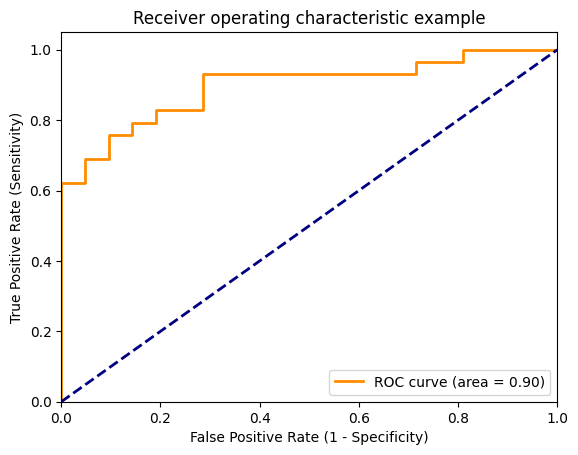

In [149]:
# compute ROC curve and AUC 
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

plt.show()




In [150]:
# Print table of sensitivity, specificity, PPV, NPV, FPR, FNR, TPR, TNR
thresholds = np.linspace(0, 1, 100)
sensitivities = []
specificities = []
npvs = []
ppvs = []
tps = []
fps = []
tns = []
fns = []

for threshold in thresholds:
    y_pred_thresholded = y_pred > threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_thresholded).ravel()
    tps.append(tp)
    fps.append(fp)
    tns.append(tn)
    fns.append(fn)
    sensitivities.append(tp / (tp + fn))
    specificities.append(tn / (tn + fp))
    npvs.append(tn / (tn + fn))
    ppvs.append(tp / (tp + fp))

# make a dataframe with the results
df_results = pd.DataFrame({'threshold': thresholds, 'sensitivity': sensitivities, 'specificity': specificities, 'npv': npvs, 'ppv': ppvs, 'tp': tps, 'fp': fps, 'tn': tns, 'fn': fns})

# calculate the other metrics
df_results['fpr'] = df_results['fp'] / (df_results['fp'] + df_results['tn'])
df_results['tpr'] = df_results['tp'] / (df_results['tp'] + df_results['fn'])
df_results['fnr'] = df_results['fn'] / (df_results['fn'] + df_results['tp'])
df_results['tnr'] = df_results['tn'] / (df_results['tn'] + df_results['fp'])

# Round to three decimal places
df_results = df_results.round(3)

# remove repeated values
df_results = df_results.drop_duplicates(subset=['sensitivity'], keep='last')

df_results


,threshold,sensitivity,specificity,npv,ppv,tp,fp,tn,fn,fpr,tpr,fnr,tnr
59,0.596,1.000,0.095,1.000,0.604,29,19,2,0,0.905,1.000,0.000,0.095
60,0.606,0.966,0.238,0.833,0.636,28,16,5,1,0.762,0.966,0.034,0.238
68,0.687,0.931,0.714,0.882,0.818,27,6,15,2,0.286,0.931,0.069,0.714
69,0.697,0.897,0.714,0.833,0.812,26,6,15,3,0.286,0.897,0.103,0.714
70,0.707,0.862,0.714,0.789,0.806,25,6,15,4,0.286,0.862,0.138,0.714
74,0.747,0.828,0.762,0.762,0.828,24,5,16,5,0.238,0.828,0.172,0.762
80,0.808,0.759,0.905,0.731,0.917,22,2,19,7,0.095,0.759,0.241,0.905
85,0.859,0.690,0.952,0.690,0.952,20,1,20,9,0.048,0.690,0.310,0.952
94,0.949,0.655,0.952,0.667,0.950,19,1,20,10,0.048,0.655,0.345,0.952
98,0.990,0.621,1.000,0.656,1.000,18,0,21,11,0.000,0.621,0.379,1.000


## Computing the AUC for Pipelle

### Removing inconclusives

In [30]:
df_pipelle = pd.read_csv('../data/pipelle_results_20250121.csv' , sep='\t', index_col=0, header=0)

df_pipelle['Pathology'] = df_pipelle['Pathology'].replace({"Adenocarcinoma de endometrio": 1, "Benigna": 0})
df_pipelle['Pathology'] = pd.to_numeric(df_pipelle['Pathology'], errors='coerce')

# Remove "Material Insuficiente o ausencia de diagnóstico" values
df_pipelle = df_pipelle[df_pipelle['Result'] != "Material Insuficiente o ausencia de diagnóstico"]

df_pipelle['Result'] = df_pipelle['Result'].replace({"Material Insuficiente o ausencia de diagnóstico": 1, "Cáncer": 1})
df_pipelle['Result'] = pd.to_numeric(df_pipelle['Result'], errors='coerce')
df_pipelle['Result'] = df_pipelle['Result'].fillna(0)


In [31]:
# Drop nan values and duplicate indexes
df_pipelle = df_pipelle.dropna()
df_pipelle = df_pipelle[~df_pipelle.index.duplicated(keep='first')]

In [32]:
df_pipelle.shape[0]

626

In [33]:
# Compute the ROC using "Pathology" as the target variable, and the "Result" column as the prediction
# getting all the thresholds, fpr, tpr and roc_auc
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(df_pipelle['Pathology'], df_pipelle['Result'])
roc_auc = auc(fpr, tpr)

roc_auc

0.9747622841965472

In [34]:
# make the table of the sensitivity	specificity	npv	ppv	tp	fp	tn	fn	fpr	tpr	fnr	tnr for all the thresholds
sensitivities = []
specificities = []
npvs = []
ppvs = []
tps = []
fps = []
tns = []
fns = []

for threshold in thresholds:
    y_pred_thresholded = df_pipelle['Result'] > threshold
    tn, fp, fn, tp = confusion_matrix(df_pipelle['Pathology'], y_pred_thresholded).ravel()
    tps.append(tp)
    fps.append(fp)
    tns.append(tn)
    fns.append(fn)
    sensitivities.append(tp / (tp + fn))
    specificities.append(tn / (tn + fp))
    npvs.append(tn / (tn + fn))
    ppvs.append(tp / (tp + fp))

# make a dataframe with the results
df_results = pd.DataFrame({'threshold': thresholds, 'sensitivity': sensitivities, 'specificity': specificities, 'npv': npvs, 'ppv': ppvs, 'tp': tps, 'fp': fps, 'tn': tns, 'fn': fns})
# remove repeated values
df_results = df_results.drop_duplicates(subset=['sensitivity'], keep='last')

df_results['fpr'] = df_results['fp'] / (df_results['fp'] + df_results['tn'])
df_results['tpr'] = df_results['tp'] / (df_results['tp'] + df_results['fn'])
df_results['fnr'] = df_results['fn'] / (df_results['fn'] + df_results['tp'])
df_results['tnr'] = df_results['tn'] / (df_results['tn'] + df_results['fp'])

# Round to three decimal places
df_results = df_results.round(3)

df_results

,threshold,sensitivity,specificity,npv,ppv,tp,fp,tn,fn,fpr,tpr,fnr,tnr
1,1.0,0.000,1.000,0.599,NaN,0,0,375,251,0.000,0.000,1.000,1.000
2,0.0,0.952,0.997,0.969,0.996,239,1,374,12,0.003,0.952,0.048,0.997


### Considering inconclusive as positives

In [35]:
df_pipelle = pd.read_csv('../data/pipelle_results_20250121.csv' , sep='\t', index_col=0, header=0)

df_pipelle['Pathology'] = df_pipelle['Pathology'].replace({"Adenocarcinoma de endometrio": 1, "Benigna": 0})
df_pipelle['Pathology'] = pd.to_numeric(df_pipelle['Pathology'], errors='coerce')


df_pipelle['Result'] = df_pipelle['Result'].replace({"Material Insuficiente o ausencia de diagnóstico": 1, "Cáncer": 1})
df_pipelle['Result'] = pd.to_numeric(df_pipelle['Result'], errors='coerce')
df_pipelle['Result'] = df_pipelle['Result'].fillna(0)


In [36]:
# Drop nan values and duplicate indexes
df_pipelle = df_pipelle.dropna()
df_pipelle = df_pipelle[~df_pipelle.index.duplicated(keep='first')]

In [37]:
df_pipelle.shape[0]

737

In [38]:
# Compute the ROC using "Pathology" as the target variable, and the "Result" column as the prediction
# getting all the thresholds, fpr, tpr and roc_auc
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(df_pipelle['Pathology'], df_pipelle['Result'])
roc_auc = auc(fpr, tpr)

roc_auc

0.8735449312440038

In [39]:
# make the table of the sensitivity	specificity	npv	ppv	tp	fp	tn	fn	fpr	tpr	fnr	tnr for all the thresholds
sensitivities = []
specificities = []
npvs = []
ppvs = []
tps = []
fps = []
tns = []
fns = []

for threshold in thresholds:
    y_pred_thresholded = df_pipelle['Result'] > threshold
    tn, fp, fn, tp = confusion_matrix(df_pipelle['Pathology'], y_pred_thresholded).ravel()
    tps.append(tp)
    fps.append(fp)
    tns.append(tn)
    fns.append(fn)
    sensitivities.append(tp / (tp + fn))
    specificities.append(tn / (tn + fp))
    npvs.append(tn / (tn + fn))
    ppvs.append(tp / (tp + fp))

# make a dataframe with the results
df_results = pd.DataFrame({'threshold': thresholds, 'sensitivity': sensitivities, 'specificity': specificities, 'npv': npvs, 'ppv': ppvs, 'tp': tps, 'fp': fps, 'tn': tns, 'fn': fns})
# remove repeated values
df_results = df_results.drop_duplicates(subset=['sensitivity'], keep='last')

df_results['fpr'] = df_results['fp'] / (df_results['fp'] + df_results['tn'])
df_results['tpr'] = df_results['tp'] / (df_results['tp'] + df_results['fn'])
df_results['fnr'] = df_results['fn'] / (df_results['fn'] + df_results['tp'])
df_results['tnr'] = df_results['tn'] / (df_results['tn'] + df_results['fp'])

# Round to three decimal places
df_results = df_results.round(3)

df_results

,threshold,sensitivity,specificity,npv,ppv,tp,fp,tn,fn,fpr,tpr,fnr,tnr
1,1.0,0.000,1.000,0.640,NaN,0,0,472,265,0.000,0.000,1.000,1.000
2,0.0,0.955,0.792,0.969,0.721,253,98,374,12,0.208,0.955,0.045,0.792
